# Python demo for the 2018 BHI & BSN Data Challenge

This notebook provides a simple introduction to analysing the MIMIC-III database. It was created as a demonstrator for the [2018 BHI & BSN Data Challenge](https://mimic.physionet.org/events/bhibsn-challenge/), which explores the following question:

> Are patients admitted to the intensive care unit (ICU) on a weekend more likely to die in the hospital than those admitted on a weekday?

We have provided an example slide template for final presentations (`slide-template.pptx`) at: https://github.com/MIT-LCP/bhi-bsn-challenge. There is no obligation to use it!



## Background on MIMIC-III

MIMIC-III (‘Medical Information Mart for Intensive Care’) is a large, single-center database comprising information relating to patients admitted to critical care units at a large tertiary care hospital. 

Data includes vital signs, medications, laboratory measurements, observations and notes charted by care providers, fluid balance, procedure codes, diagnostic codes, imaging reports, hospital length of stay, survival data, and more. 

For details, see: https://mimic.physionet.org/. The data is downloaded as 26 CSV files, which can then be loaded into a database system. Scripts for loading the data into Postgres are provided in the [MIMIC Code Repository](https://mimic.physionet.org/gettingstarted/dbsetup/). A demo dataset is also available: https://mimic.physionet.org/gettingstarted/demo/

Points to note:

- A patient-level shift has been applied to dates. Day of week is retained. 
- Patients aged >89 years on first admission have been reassigned an age of ~300 years.
- Patients may have multiple hospital admissions. Each hospital admission may comprise multiple ICU stays (e.g. a patient may visit the ICU, leave for surgery, and then return to the ICU for recovery, all within a single hospital admission).

If you need help getting set up with access to MIMIC-III, please contact `data-challenge@physionet.org`.


# Import libraries

In [54]:
# Data processing libraries
import pandas as pd
import numpy as np
import itertools

# Database libraries
import psycopg2
import getpass

# Stats libraries
from tableone import TableOne
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats

# Image libraries
# https://jakevdp.github.io/pdvega/
# jupyter nbextension enable vega3 --py --sys-prefix
import matplotlib.pyplot as plt
import pdvega 
%matplotlib inline

# Connect to the MIMIC-III database

If you have created an instance of the MIMIC-III database, then you should be able to connect with the following settings (or similar). If you need help getting set up with access to MIMIC-III, please contact `data-challenge@physionet.org`.

In [55]:
# Create a database connection
user = 'postgres'
host = 'localhost'
dbname = 'mimic'
schema = 'public, mimiciii'

In [56]:
# Connect to the database
con = psycopg2.connect(dbname=dbname, user=user, host=host, 
                       password=getpass.getpass(prompt='Password:'.format(user)))
cur = con.cursor()
cur.execute('SET search_path to {}'.format(schema))

Password:········


# Extract data from MIMIC-III and assign to a Pandas DataFrame

The following query extracts a simple dataset from the MIMIC-III database, comprising demographics, hospital and ICU admission times, and a severity of illness score ([OASIS](https://www.ncbi.nlm.nih.gov/pubmed/23660729)).

Before running this query, you must first build the `icustay_detail` and `oasis` materialized views. Code for building these views is available in the MIMIC Code Repository:
- `icustay_detail`: https://github.com/MIT-LCP/mimic-code/tree/master/concepts/demographics
- `oasis`: https://github.com/MIT-LCP/mimic-code/tree/master/concepts/severityscores

You will notice that our example restricts the analysis to:

- first hospital admissions 
- patients who were `>= 16` years at time of hospital admission.
- the first ICU stay (patients may move to the ICU multiple times within a hospital stay)

In [57]:
# Run query and assign the results to a Pandas DataFrame
# Requires the icustay_detail view from:
# https://github.com/MIT-LCP/mimic-code/tree/master/concepts/demographics
# And the OASIS score from:
# https://github.com/MIT-LCP/mimic-code/tree/master/concepts/severityscores
query = \
"""
WITH first_icu AS (
    SELECT i.subject_id, i.hadm_id, i.icustay_id, i.gender, i.admittime admittime_hospital, 
      i.dischtime dischtime_hospital, i.los_hospital, i.age, i.admission_type, 
      i.hospital_expire_flag, i.intime intime_icu, i.outtime outtime_icu, i.los_icu, 
      s.first_careunit
    FROM icustay_detail i
    LEFT JOIN icustays s
    ON i.icustay_id = s.icustay_id
    WHERE i.hospstay_seq = 1
      AND i.icustay_seq = 1
      AND i.age >= 16
)
SELECT f.*, o.icustay_expire_flag, o.oasis, o.oasis_prob
FROM first_icu f
LEFT JOIN oasis o
ON f.icustay_id = o.icustay_id;
"""

data = pd.read_sql_query(query,con)

# Check the extracted data

It is always a good idea to inspect the data after you have extracted it.  We will look at the first six patients (rows), and then check the number of rows, and get some summary statistics of the dataset.

In [58]:
data.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'gender', 'admittime_hospital',
       'dischtime_hospital', 'los_hospital', 'age', 'admission_type',
       'hospital_expire_flag', 'intime_icu', 'outtime_icu', 'los_icu',
       'first_careunit', 'icustay_expire_flag', 'oasis', 'oasis_prob'],
      dtype='object')

In [59]:
data.head()

,subject_id,hadm_id,icustay_id,gender,admittime_hospital,dischtime_hospital,los_hospital,age,admission_type,hospital_expire_flag,intime_icu,outtime_icu,los_icu,first_careunit,icustay_expire_flag,oasis,oasis_prob
0,27513,163557,200003,M,2199-08-02 17:02:00,2199-08-22 19:00:00,20.0819,48.2960,EMERGENCY,0,2199-08-02 19:50:04,2199-08-08 17:09:18,5.8884,SICU,0,35,0.152892
1,20707,129310,200007,M,2109-02-17 10:02:00,2109-02-20 15:47:00,3.2396,43.3450,EMERGENCY,0,2109-02-17 10:03:37,2109-02-18 17:03:12,1.2914,CCU,0,26,0.054187
2,9514,127229,200014,M,2105-02-16 23:15:00,2105-02-21 13:46:00,4.6049,84.7300,EMERGENCY,0,2105-02-16 23:16:48,2105-02-18 16:53:29,1.7338,SICU,0,56,0.724202
3,21789,112486,200019,F,2178-07-08 09:02:00,2178-07-11 06:45:00,2.9049,82.8831,EMERGENCY,1,2178-07-08 09:03:12,2178-07-11 10:28:40,3.0594,CCU,1,47,0.454600
4,41710,181955,200028,M,2133-10-29 10:00:00,2133-11-01 14:54:00,3.2042,64.8677,ELECTIVE,0,2133-10-29 17:13:50,2133-11-01 14:55:14,2.9038,CCU,0,35,0.152892


In [60]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
subject_id,38557.0,38266.300542,29376.635331,3.000000,13980.000000,27912.000000,62965.000000,99999.000000
hadm_id,38557.0,150038.112976,28944.685351,100001.000000,124930.000000,150093.000000,175223.000000,199999.000000
icustay_id,38557.0,250221.770677,28913.979227,200003.000000,225240.000000,250275.000000,275288.000000,299999.000000
los_hospital,38557.0,9.897278,10.691943,-0.945100,4.047900,6.893800,11.883300,294.660400
age,38557.0,74.565250,55.113322,16.016300,52.321900,65.672400,77.904100,310.280900
hospital_expire_flag,38557.0,0.114739,0.318711,0.000000,0.000000,0.000000,0.000000,1.000000
los_icu,38555.0,4.058682,6.013646,0.000100,1.186250,2.095200,4.092100,153.928000
icustay_expire_flag,38557.0,0.082838,0.275641,0.000000,0.000000,0.000000,0.000000,1.000000
oasis,38557.0,31.159841,8.963934,3.000000,25.000000,31.000000,37.000000,70.000000
oasis_prob,38557.0,0.143440,0.142979,0.003042,0.048012,0.097783,0.188911,0.939936


# Add day of week to DataFrame

If we are going to examine the weekend effect, we need to pull this out of the dataset, as you can see, all we have above are dates. We will define a weekend, as anytime between Saturday (00:00:00) until Sunday (23:59:59). The dates above are shifted, and that's why they look odd, but they are matched on the day of week, so this aspect is preserved.

In [61]:
data['admitday_hospital'] = data.admittime_hospital.dt.weekday_name
data['dischday_hospital'] = data.dischtime_hospital.dt.weekday_name
data['inday_icu'] = data.intime_icu.dt.weekday_name
data['inday_icu_seq'] = data.intime_icu.dt.weekday
data['outday_icu'] = data.outtime_icu.dt.weekday_name
data.head()

,subject_id,hadm_id,icustay_id,gender,admittime_hospital,dischtime_hospital,los_hospital,age,admission_type,hospital_expire_flag,...,los_icu,first_careunit,icustay_expire_flag,oasis,oasis_prob,admitday_hospital,dischday_hospital,inday_icu,inday_icu_seq,outday_icu
0,27513,163557,200003,M,2199-08-02 17:02:00,2199-08-22 19:00:00,20.0819,48.2960,EMERGENCY,0,...,5.8884,SICU,0,35,0.152892,Friday,Thursday,Friday,4,Thursday
1,20707,129310,200007,M,2109-02-17 10:02:00,2109-02-20 15:47:00,3.2396,43.3450,EMERGENCY,0,...,1.2914,CCU,0,26,0.054187,Sunday,Wednesday,Sunday,6,Monday
2,9514,127229,200014,M,2105-02-16 23:15:00,2105-02-21 13:46:00,4.6049,84.7300,EMERGENCY,0,...,1.7338,SICU,0,56,0.724202,Monday,Saturday,Monday,0,Wednesday
3,21789,112486,200019,F,2178-07-08 09:02:00,2178-07-11 06:45:00,2.9049,82.8831,EMERGENCY,1,...,3.0594,CCU,1,47,0.454600,Wednesday,Saturday,Wednesday,2,Saturday
4,41710,181955,200028,M,2133-10-29 10:00:00,2133-11-01 14:54:00,3.2042,64.8677,ELECTIVE,0,...,2.9038,CCU,0,35,0.152892,Thursday,Sunday,Thursday,3,Sunday


In [62]:
data['inday_icu'].value_counts()

Friday       6263
Tuesday      6141
Monday       6097
Wednesday    5985
Thursday     5876
Saturday     4235
Sunday       3960
Name: inday_icu, dtype: int64

In [63]:
# create weekday vs weekend column for icu_intime 
data['inday_icu_wkd'] = np.where(data.intime_icu.dt.weekday <= 4, 
                                 'weekday','weekend')
data['inday_icu_wkd'].value_counts()

weekday    30362
weekend     8195
Name: inday_icu_wkd, dtype: int64

# Produce some Summary Statistics by DOW and Weekday vs. Weekend

Next, it's good to look at some basic summaries of the data.  We will compute simple averages and percentages/counts for each of the variables we have extracted, and look at it by day of week and weekend.

In [64]:
data.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'gender', 'admittime_hospital',
       'dischtime_hospital', 'los_hospital', 'age', 'admission_type',
       'hospital_expire_flag', 'intime_icu', 'outtime_icu', 'los_icu',
       'first_careunit', 'icustay_expire_flag', 'oasis', 'oasis_prob',
       'admitday_hospital', 'dischday_hospital', 'inday_icu', 'inday_icu_seq',
       'outday_icu', 'inday_icu_wkd'],
      dtype='object')

In [65]:
columns = ['gender', 'los_hospital', 'age', 'admission_type', 'hospital_expire_flag', 
           'los_icu','icustay_expire_flag', 'oasis', 'oasis_prob', 'first_careunit',
           'inday_icu_wkd']

groupby = 'inday_icu'

pval = False

categorical = ['gender','admission_type','hospital_expire_flag','icustay_expire_flag',
               'first_careunit','inday_icu_wkd']

t = TableOne(data, columns=columns, categorical=categorical, groupby=groupby, pval=pval)
t.tableone

Grouped by inday_icu                 \
                                             Friday         Monday   
variable             level                                           
n                                              6263           6097   
admission_type       ELECTIVE          1016 (16.22)   1265 (20.75)   
                     EMERGENCY         5118 (81.72)   4687 (76.87)   
                     URGENT              129 (2.06)     145 (2.38)   
age                                   74.56 (53.22)  73.13 (51.37)   
first_careunit       CCU                838 (13.38)    918 (15.06)   
                     CSRU              1416 (22.61)   1632 (26.77)   
                     MICU              2139 (34.15)   1940 (31.82)   
                     SICU              1044 (16.67)    865 (14.19)   
                     TSICU              826 (13.19)    742 (12.17)   
gender               F                  2662 (42.5)   2559 (41.97)   
                     M                  3601 (57.5)   3538 (58.03)   
hospital_expire_flag 0                 5576 (89.03)   5468 (89.68)   
                     1                  687 (10.97)    629 (10.32)   
icustay_expire_flag  0                  5768 (92.1)   5650 (92.67)   
                     1                    495 (7.9)     447 (7.33)   
inday_icu_wkd        weekday           6263 (100.0)   6097 (100.0)   
                     weekend                                         
los_hospital                          10.23 (11.61)    9.71 (9.92)   
los_icu                                 4.15 (6.19)    3.83 (5.52)   
oasis                                  31.17 (9.02)   31.21 (8.77)   
oasis_prob                              0.14 (0.14)    0.14 (0.14)   

                                                                             \
                                     Saturday         Sunday       Thursday   
variable             level                                                    
n                                        4235           3960           5876   
admission_type       ELECTIVE      162 (3.83)     101 (2.55)     999 (17.0)   
                     EMERGENCY   3852 (90.96)   3681 (92.95)   4746 (80.77)   
                     URGENT        221 (5.22)     178 (4.49)     131 (2.23)   
age                             73.92 (58.58)  75.26 (60.66)  75.51 (55.46)   
first_careunit       CCU          695 (16.41)    621 (15.68)    850 (14.47)   
                     CSRU           237 (5.6)      194 (4.9)   1282 (21.82)   
                     MICU        1765 (41.68)   1706 (43.08)   2020 (34.38)   
                     SICU         743 (17.54)    743 (18.76)    996 (16.95)   
                     TSICU        795 (18.77)    696 (17.58)    728 (12.39)   
gender               F           1857 (43.85)   1736 (43.84)    2603 (44.3)   
                     M           2378 (56.15)   2224 (56.16)    3273 (55.7)   
hospital_expire_flag 0           3658 (86.38)   3388 (85.56)   5202 (88.53)   
                     1            577 (13.62)    572 (14.44)    674 (11.47)   
icustay_expire_flag  0           3811 (89.99)    3548 (89.6)   5399 (91.88)   
                     1            424 (10.01)     412 (10.4)     477 (8.12)   
inday_icu_wkd        weekday                                   5876 (100.0)   
                     weekend     4235 (100.0)   3960 (100.0)                  
los_hospital                    10.00 (10.84)   9.82 (10.70)   9.88 (10.90)   
los_icu                           4.42 (6.58)    4.44 (6.29)    3.96 (6.12)   
oasis                            31.49 (9.27)   32.07 (9.02)   31.10 (8.82)   
oasis_prob                        0.15 (0.15)    0.16 (0.15)    0.14 (0.14)   

                                                                     
                                      Tuesday      Wednesday isnull  
variable             level                                           
n                                        6141           5985         
admission_type       ELE

In [66]:
columns = ['gender', 'los_hospital', 'age', 'admission_type', 'hospital_expire_flag', 
           'los_icu','icustay_expire_flag', 'oasis', 'oasis_prob', 'first_careunit']

groupby = 'inday_icu_wkd'

pval = False

categorical = ['gender','admission_type','hospital_expire_flag','icustay_expire_flag',
               'first_careunit']

t = TableOne(data, columns=columns, categorical=categorical, groupby=groupby, pval=pval)
t.tableone

Grouped by inday_icu_wkd                 \
                                                 isnull        weekday   
variable             level                                               
n                                                                30362   
admission_type       ELECTIVE                         0   5815 (19.15)   
                     EMERGENCY                           23855 (78.57)   
                     URGENT                                 692 (2.28)   
age                                                   0  74.56 (53.84)   
first_careunit       CCU                              0   4376 (14.41)   
                     CSRU                                 7173 (23.62)   
                     MICU                                10138 (33.39)   
                     SICU                                 4876 (16.06)   
                     TSICU                                3799 (12.51)   
gender               F                                0  13131 (43.25)   
                     M                                   17231 (56.75)   
hospital_expire_flag 0                                0  27087 (89.21)   
                     1                                    3275 (10.79)   
icustay_expire_flag  0                                0  28004 (92.23)   
                     1                                     2358 (7.77)   
los_hospital                                          0   9.89 (10.67)   
los_icu                                               2    3.96 (5.89)   
oasis                                                 0   30.99 (8.90)   
oasis_prob                                            0    0.14 (0.14)   

                                               
                                      weekend  
variable             level                     
n                                        8195  
admission_type       ELECTIVE      263 (3.21)  
                     EMERGENCY   7533 (91.92)  
                     URGENT        399 (4.87)  
age                             74.57 (59.59)  
first_careunit       CCU         1316 (16.06)  
                     CSRU          431 (5.26)  
                     MICU        3471 (42.36)  
                     SICU        1486 (18.13)  
                     TSICU       1491 (18.19)  
gender               F           3593 (43.84)  
                     M           4602 (56.16)  
hospital_expire_flag 0           7046 (85.98)  
                     1           1149 (14.02)  
icustay_expire_flag  0            7359 (89.8)  
                     1             836 (10.2)  
los_hospital                     9.91 (10.77)  
los_icu                           4.43 (6.44)  
oasis                            31.77 (9.15)  
oasis_prob                        0.15 (0.15)

It looks like there's a higher rate of hospital mortality (14.0% vs 10.8%) and ICU mortality (10.2% vs 7.8%) on weekends when compared to weekdays.  There are also statistically significant differences between several other important variables, including: admission type, disease severity (OASIS), and the patient's first care unit, suggesting that these groups may be fundamentally different in some way.  Let's explore this a little further.

# Plot the data


In [67]:
# Pivot data to summarise by day
dat_dow = data.groupby(['admission_type',
                        'inday_icu_seq'])['hospital_expire_flag'].mean().reset_index()

dat_dow = dat_dow.pivot(index='inday_icu_seq', 
                        columns='admission_type', values='hospital_expire_flag')

dat_dow

admission_type,ELECTIVE,EMERGENCY,URGENT
inday_icu_seq,,,
0,0.020553,0.124387,0.137931
1,0.019350,0.130315,0.082759
2,0.026549,0.127391,0.112676
3,0.027027,0.133165,0.114504
4,0.026575,0.126612,0.093023
5,0.080247,0.137072,0.162896
6,0.089109,0.146971,0.123596


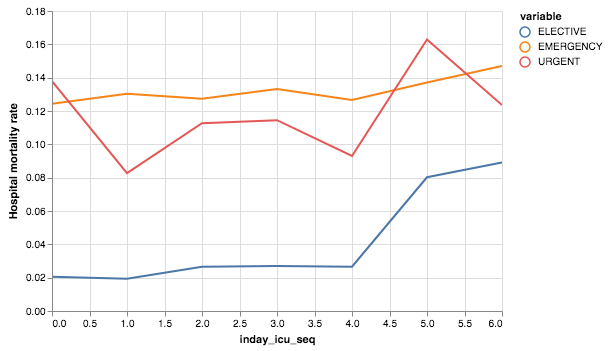

In [85]:
# day_map = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
dat_dow.vgplot.line(value_name='Hospital mortality rate')

In [16]:
dat_wkd = data.groupby(['admission_type','inday_icu_wkd'])['hospital_expire_flag'].mean().reset_index()
dat_wkd = dat_wkd.pivot(index='inday_icu_wkd', columns='admission_type', values='hospital_expire_flag')
dat_wkd.head()

admission_type,ELECTIVE,EMERGENCY,URGENT
inday_icu_wkd,,,
weekday,0.023732,0.128359,0.108382
weekend,0.083650,0.141909,0.145363


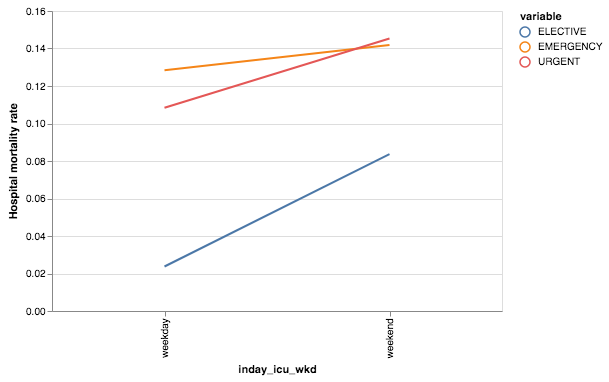

In [17]:
dat_wkd.vgplot.line(value_name='Hospital mortality rate')

# Model building

Let's try to incorporate what we saw above into a very simple model. We will use logistic regression with hospital mortality as our outcome. First an unadjusted estimate, and then we will try to adjust for admission type.

The unadjusted analysis should mirror pretty closely what we saw in the one of the tables above. The odds ratio corresponding with 14.0% and 10.8% mortality in the the weekend and weekday groups, respectively, is about 1.35. Performing logistic regression on the same data:

In [18]:
# R style syntax
simple_glm = smf.glm('hospital_expire_flag ~ C(inday_icu_wkd)', 
                     data=data, family=sm.families.Binomial()).fit()
simple_glm.summary2()

# Alternative syntax
# y = data.hospital_expire_flag
# X = sm.tools.add_constant(data.inday_icu_wkd.factorize()[0])
# simple_glm = sm.GLM(y, X, family=sm.families.Binomial()).fit()
# simple_glm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Results: Generalized linear model
=============================================================================
Model:                  GLM                    AIC:              27416.8526  
Link Function:          logit                  BIC:              -379723.8199
Dependent Variable:     hospital_expire_flag   Log-Likelihood:   -13706.     
Date:                   2018-02-08 09:14       LL-Null:          -13738.     
No. Observations:       38557                  Deviance:         27413.      
Df Model:               1                      Pearson chi2:     3.86e+04    
Df Residuals:           38555                  Scale:            1.0000      
Method:                 IRLS                                                 
-----------------------------------------------------------------------------
                             Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------
Intercept                   -2.1127   0.0185 -114.2000 0.0000 -2.1490 -2.0765
C(inday_icu_wkd)[T.weekend]  0.2992   0.0368    8.1288 0.0000  0.2270  0.3713
=============================================================================

"""

...yields the same results. The coefficient shown above for weekend is on the log scale, so when we exponentiate it, we get the odds-ratio: `exp(0.2992) = 1.35`. So, looking at these crude rates and odds ratios, we can see that patients admitted on a weekend have about a 35% increase in the odds of dying in the hospital when compared to those on a weekday. This effect is statistically significant (p<0.001). 

Are we done?

I hope not. We saw from the tables and figures above, there is likely some confounding and maybe even effect modification happening. Next let''s look at admission type and weekend ICU admission in the same model. There are two such models we could consider. 

The first adjusts for admission type, but assumes that the effect of weekend admission is the same regardless if the patient is of any of the admission types. The second one adjusts for admission type, but then allows the effect of weekend ICU admission to vary across the different levels of admission type. 

The first type of model would be able to account for confounding (when a nuisance variable is associated with both the outcome and the exposure/variable of interest), while the second permits what is called effect modification or a statistical interaction. 

Interactions are sometimes difficult to understand, but if ignored, can lead to incorrect conclusions about the effect of one or more of the variables. In this example, we fit both models, output estimates of the log-odds ratios, and perform a hypothesis test which evaluates the statistical significance of dropping one of the variables. Below is the resulting output:

In [19]:
# Without effect modification
adj_glm = smf.glm('hospital_expire_flag ~ C(inday_icu_wkd) + C(admission_type)', 
                     data=data, family=sm.families.Binomial()).fit()
adj_glm.summary2()
# drop1(adj.glm,test="Chisq")

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Generalized linear model
===============================================================================
Model:                  GLM                     AIC:               26729.0141  
Link Function:          logit                   BIC:               -380394.5386
Dependent Variable:     hospital_expire_flag    Log-Likelihood:    -13361.     
Date:                   2018-02-08 09:14        LL-Null:           -13738.     
No. Observations:       38557                   Deviance:          26721.      
Df Model:               3                       Pearson chi2:      3.85e+04    
Df Residuals:           38553                   Scale:             1.0000      
Method:                 IRLS                                                   
-------------------------------------------------------------------------------
                                Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------------
Intercept                      -3.6173   0.0801 -45.1364 0.0000 -3.7743 -3.4602
C(inday_icu_wkd)[T.weekend]     0.1444   0.0372   3.8871 0.0001  0.0716  0.2172
C(admission_type)[T.EMERGENCY]  1.6944   0.0822  20.6095 0.0000  1.5333  1.8555
C(admission_type)[T.URGENT]     1.5881   0.1231  12.9034 0.0000  1.3469  1.8293
===============================================================================

"""

In [20]:
# With effect modification
adj_glm_int = smf.glm('hospital_expire_flag ~ C(inday_icu_wkd) * C(admission_type)', 
                     data=data, family=sm.families.Binomial()).fit()
adj_glm_int.summary2()
# drop1(adj.glm,test="Chisq")

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                     Results: Generalized linear model
===========================================================================================================
Model:                            GLM                              AIC:                        26712.4403  
Link Function:                    logit                            BIC:                        -380393.9926
Dependent Variable:               hospital_expire_flag             Log-Likelihood:             -13350.     
Date:                             2018-02-08 09:15                 LL-Null:                    -13738.     
No. Observations:                 38557                            Deviance:                   26700.      
Df Model:                         5                                Pearson chi2:               3.86e+04    
Df Residuals:                     38551                            Scale:                      1.0000      
Method:                           IRLS                                                                     
-----------------------------------------------------------------------------------------------------------
                                                            Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                                  -3.7169   0.0862 -43.1428 0.0000 -3.8858 -3.5481
C(inday_icu_wkd)[T.weekend]                                 1.3232   0.2388   5.5409 0.0000  0.8551  1.7912
C(admission_type)[T.EMERGENCY]                              1.8014   0.0883  20.4002 0.0000  1.6283  1.9744
C(admission_type)[T.URGENT]                                 1.6095   0.1496  10.7598 0.0000  1.3164  1.9027
C(inday_icu_wkd)[T.weekend]:C(admission_type)[T.EMERGENCY] -1.2071   0.2418  -4.9913 0.0000 -1.6812 -0.7331
C(inday_icu_wkd)[T.weekend]:C(admission_type)[T.URGENT]    -0.9872   0.3036  -3.2521 0.0011 -1.5822 -0.3922
===========================================================================================================

"""

In [1]:
# Create data structure to hold odds of hospital death
def expand_grid(data_dict):
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys())

weekend_grid = expand_grid({'inday_icu_wkd': ['weekday', 'weekend'],
                            'admission_type': ['ELECTIVE', 'EMERGENCY', 'URGENT']})

weekend_grid

NameError: name 'itertools' is not defined

In the first model (no interaction), we see that although the effect of weekend is almost halved, it remains statistically significant, after adjusting for admission type (p<0.001).

In the second model, we are primarily interested in the significance of the interaction.  We can see when assessed with the `drop1` function, the interaction (`weekend:admission_type`) is statistically significant (p<0.001), suggesting that the effect of weekend may be different depending on which hospital admission type you are.  How exactly to interpret this:

One way of looking at this complexity is by computing the odds ratio in each of the levels of admission type.  We can do this using the `predict` function, which by default outputs the log-odds of death.  If for each hospital admission type, we calculate the log odds of death for each of the levels of weekend,

In [46]:
def prob2logodds(prob):
    odds = prob / (1 - prob)
    logodds = np.log(odds)
    return logodds

In [47]:
weekend_grid['predict'] = adj_glm_int.predict(weekend_grid[['inday_icu_wkd','admission_type']])
weekend_grid['log_odds'] = prob2logodds(weekend_grid['predict'])
weekend_grid.set_index(['inday_icu_wkd','admission_type'], inplace=True)
weekend_grid

predict  log_odds
inday_icu_wkd admission_type                    
weekday       ELECTIVE        0.023732 -3.716925
              EMERGENCY       0.128359 -1.915548
              URGENT          0.108382 -2.107381
weekend       ELECTIVE        0.083650 -2.393754
              EMERGENCY       0.141909 -1.799525
              URGENT          0.145363 -1.771439

We can now compute the log odds ratio ($log(OR) =  logOdds_{weekend} - logOdds_{weekday}$), and exponentiate to get the odds ratio:

In [48]:
diff_grid = weekend_grid.loc['weekend']['log_odds'] - weekend_grid.loc['weekday']['log_odds']
np.exp(diff_grid)

admission_type
ELECTIVE     3.755307
EMERGENCY    1.123022
URGENT       1.399257
Name: log_odds, dtype: float64

So, this mirrors what we saw above. While there may be differences between EMERGENCY and URGENT admission types, an ELECTIVE admission occurring on a weekend has an odds of mortality almost four times that of an ELECTIVE admission on a weekday. This seems particularly odd -- patients usually do not get admitted to a hospital electively on a weekend.

What do you think?

- Do patients admitted on a weekend have a higher rate of mortality than those admitted during the week?
- Who is most affected, if at all?
- What factors can you rule out might be causing this effect? e.g., is it because the patients are simply sicker on a weekend? Are they more likely to have complications?

Looking forward to see what you guys come up with!